In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Prepare data

## Read sensor ID

In [55]:
# Read sensor id
sensor_id = pd.read_csv('Data/SensorID_EPC_Survey_Open_Data.csv')

In [56]:
# Convert field to datetime type 
sensor_id['Battery Charging Start Time'] = pd.to_datetime(sensor_id['Battery Charging Start Time'], format="%d/%m/%Y %H:%M")  
sensor_id['Battery Charging End Time'] = pd.to_datetime(sensor_id['Battery Charging End Time'], format="%d/%m/%Y %H:%M")  

sensor_id['Recording Start Time (Participant)'] = pd.to_datetime(sensor_id['Recording Start Time (Participant) '], format="%d/%m/%Y %H:%M")  
sensor_id['Recording End Time (Participant)'] = pd.to_datetime(sensor_id['Recording End Time (Participant) '], format="%d/%m/%Y %H:%M")

In [57]:
# Set ID as index
sensor_id = sensor_id.set_index('ID')

In [58]:
# Define final start datetime and end datetime
# Delay 1 hour to allow the sensor settled in the indoor condition and improve the accuracy of indoor temperature measurement
sensor_id[['start_datetime']] = sensor_id[['Battery Charging Start Time']] + pd.Timedelta(hours=1)
sensor_id[['end_datetime']] = sensor_id[['Battery Charging End Time']]

sensor_id.start_datetime.fillna(sensor_id['Recording Start Time (Participant)'], inplace=True)
sensor_id.end_datetime.fillna(sensor_id['Recording End Time (Participant)'], inplace=True)

## Read sensor data

In [59]:
# Read and filter sensors data accroding to datetime
sensors_data_path = 'Data/Household Indoor Sensor Measurement Data/'

sensors_data = {}

for data_path in os.listdir(sensors_data_path):
    df = pd.read_csv(sensors_data_path+data_path)

    df['TIME'] = pd.to_datetime(df['TIME'])  

    start_date_value = sensor_id.loc[data_path[:-4]]['start_datetime']
    end_date_value = sensor_id.loc[data_path[:-4]]['end_datetime']

    df = df[(df['TIME'] >= start_date_value) & (df['TIME'] <= end_date_value)]
    df = df.set_index('TIME')

    sensors_data[data_path[:-4]] = df

## Read weather station data

In [60]:
# read data
station_limbo = pd.read_csv('Data/LIMBO.csv')

# transform date to datetime
station_limbo['Report Date / Time'] = pd.to_datetime(station_limbo['Report Date / Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# set datetime as index
station_limbo.index = station_limbo['Report Date / Time']

# Calculate temperature difference

Aggregate weather station (outdoor) and sensor (indoor) data in a hourly basis

## Weather station data

In [61]:
# Filter hourly data and groupby based on hour
station_limbo['hourly_time'] = station_limbo['Report Date / Time'].apply(lambda x: str(x)[:-6]+'h')
station_hour = station_limbo.groupby('hourly_time').agg({'Air Temperature': ['mean']})

## Sensor data

In [62]:
# Filter hourly data and groupby based on hour
for index in sensors_data:
    sensors_data[index]['time'] = sensors_data[index].index
    sensors_data[index]['hourly_time'] = sensors_data[index]['time'].apply(lambda x: str(x)[:-6]+'h')

sensors_data_hour = {}

for index in sensors_data:
    sensors_data_hour[index] = sensors_data[index].groupby('hourly_time').agg({'TEMP': ['mean']})

## Calculate temperature difference 

The "temperature difference" is calculated with the hourly mean temperaure:

"Absolute *[Hourly Mean (indoor sensor temperatures) – Hourly Mean (outdoor weather station temperatures)]*"

In [63]:
# Combine station and sensors data in a dataframe
compare_data_hour = {}

for index in sensors_data_hour:
    compare_data_hour[index] = sensors_data_hour[index].join(station_hour,how='left')

    compare_data_hour[index] = compare_data_hour[index].set_axis(['Indoor_Mean','Outdoor_Mean'], axis=1)
    
    compare_data_hour[index]['Date_hour'] = compare_data_hour[index].index

    compare_data_hour[index]['Date'] = compare_data_hour[index]['Date_hour'].apply(lambda x: x[:-4])
    compare_data_hour[index]['Hour'] = compare_data_hour[index]['Date_hour'].apply(lambda x: x[-4:])


    compare_data_hour[index] = compare_data_hour[index].reset_index()
    compare_data_hour[index]['hourly_time'] = pd.to_datetime(compare_data_hour[index]['hourly_time'])

    compare_data_hour[index] = compare_data_hour[index].set_index('hourly_time',drop=False)

    compare_data_hour[index]['mean_diff'] = (compare_data_hour[index]['Indoor_Mean'] - compare_data_hour[index]['Outdoor_Mean']).abs()

In [64]:
# Define day/night time
sunrise = 6
sunset = 20

In [65]:
# Calculate the mean of temperature difference across whole measurement period for each sensor
mean_tempdiff = {}

for index in compare_data_hour:
    df = compare_data_hour[index]
    day_df = df[(df.index.hour >= sunrise) & (df.index.hour < sunset)]
    night_df = df[(df.index.hour < sunrise) | (df.index.hour >= sunset)]

    mean_tempdiff[index] = [df['mean_diff'].mean(),day_df['mean_diff'].mean(), 
    night_df['mean_diff'].mean()]

tempdiff_all = pd.DataFrame.from_dict(mean_tempdiff,orient='index',columns=['mean','day_mean','night_mean'])

### Result for Part 4 of TBIJ report: Indoor and outdoor temperature gap

Some homes were as much as 8-10C hotter at night over the full monitoring period than the outside air temperature, according to readings at local weather stations.

In [66]:
tempdiff_all['night_mean'].nlargest(10)

BL007-28    10.021508
BL007-36     9.922896
BL007-04     8.604666
BL007-09     8.351340
BL007-48     8.302595
BL007-14     8.247516
BL007-47     8.158813
BL007-13     7.843938
BL007-43     7.820293
BL007-50     7.739167
Name: night_mean, dtype: float64

# Generating plots to visualize temperature difference

1. Visualize temperature difference with indoor and outdoor temperature

In [67]:
def plot_tempdiff_1(ID):
    # Plot difference between station and sensor data
    fig, ax1 = plt.subplots(figsize=(12, 6),dpi=150)

    # lineplot
    ax1.plot(compare_data_hour[ID]['Indoor_Mean'], label='Indoor Temperature', linestyle='-', color='tab:red')
    ax1.plot(compare_data_hour[ID]['Outdoor_Mean'], label='Outdoor Temperature', linestyle='-', color='tab:blue')

    # barplot
    ax1.bar(compare_data_hour[ID]['hourly_time'], compare_data_hour[ID]['mean_diff'], width=0.05, color='tab:grey', edgecolor="white", linewidth=0.1, label='Temperature difference')

    # show legend and title
    lines, labels = ax1.get_legend_handles_labels()
    plt.legend(lines, labels, loc='upper left')
    plt.title('Temperature Difference between Indoor and Outdoor from Sensor {} (EPC:{})'.format(ID,sensor_id.loc[ID,'Current EPC Rating ']),
                  fontsize=15)

    # set x and y label
    plt.xlabel('Date',fontsize=12)  # Change the X-axis label to 'Date'
    plt.ylabel('Temperature (°C)',fontsize=12)

    ax1.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.DAILY, interval=2)))
    plt.xticks(rotation=45,ha='right')

    # return the figure
    return plt

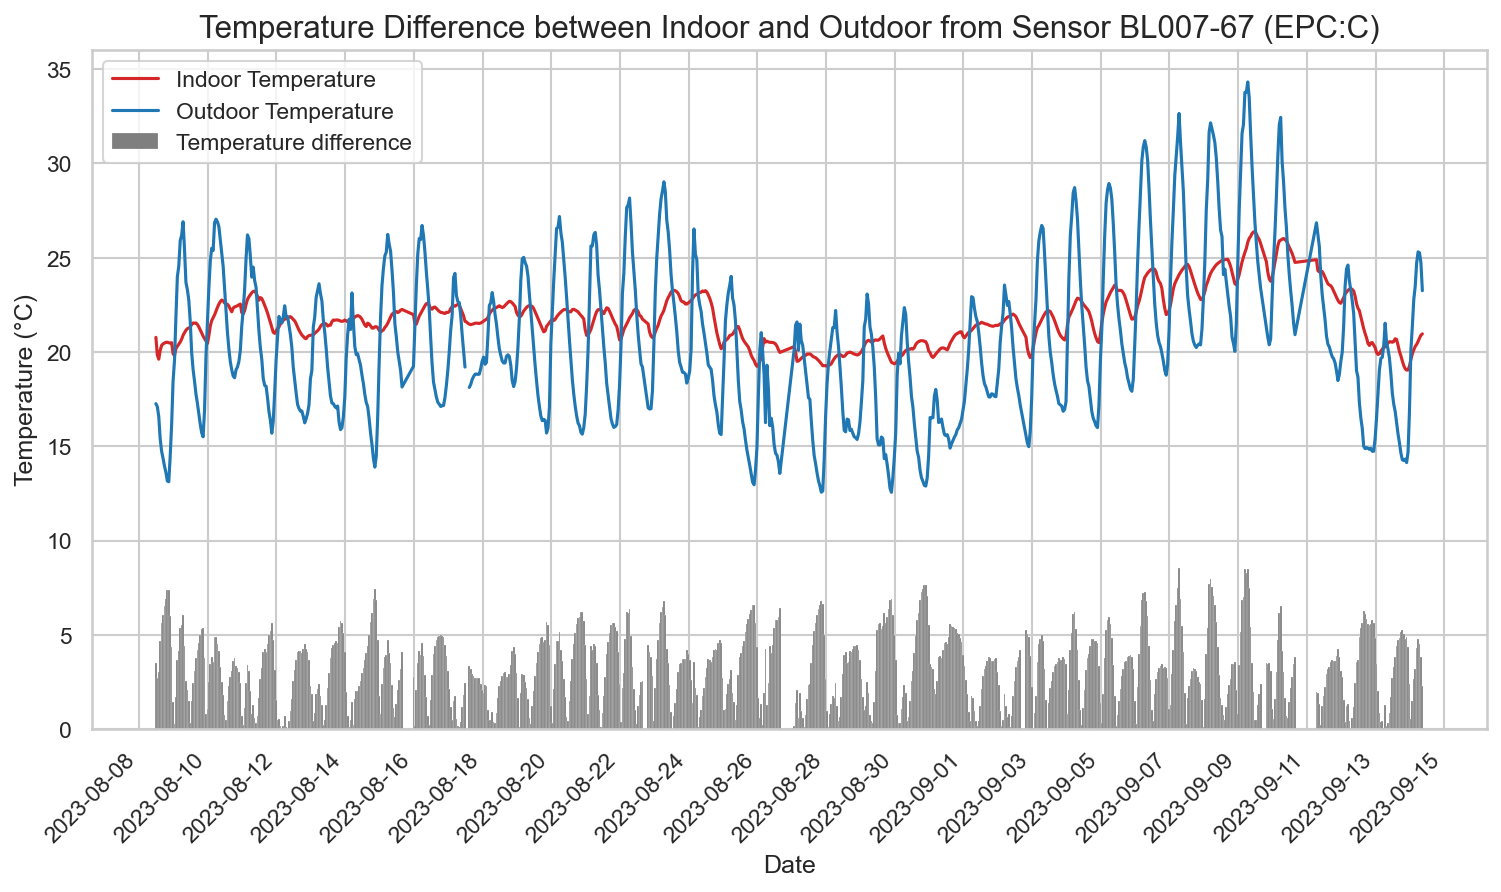

In [68]:
plot_1 = plot_tempdiff_1('BL007-67')

2. Visualize grouped temperature difference (group into days)

In [69]:
# Plot 2
# define heatwave period
heatwave_start_date = pd.to_datetime('2023-09-04')
heatwave_end_date = pd.to_datetime('2023-09-10')

# draw the temperature difference group plot
def plot_tempdiff_group (ID):
    # Set the figure size and style
    fig, ax1 = plt.subplots(figsize=(12, 6),dpi=150)
    sns.set(style="whitegrid")

    # Create a new column 'day' to group the data by day
    compare_data_hour[ID]['day'] = compare_data_hour[ID]['hourly_time'].dt.date

    # Create a box plot
    sns.boxplot(data=compare_data_hour[ID], x='day', y='mean_diff', boxprops={"facecolor": (.3, .5, .7, .5)},
        medianprops={"color": "r", "linewidth": 2})

    # Draw heatwave period
    compare_data_hour[ID]['day'] = pd.to_datetime(compare_data_hour[ID]['day'])
    if compare_data_hour[ID]['day'][-1] >= heatwave_start_date:
        start_unit = (heatwave_start_date-compare_data_hour[ID]['day'][0]).days
        end_unit = min(start_unit+6, (compare_data_hour[ID]['day'][-1]-compare_data_hour[ID]['day'][0]).days)
        plt.axvspan(start_unit-0.5, end_unit+0.5, color='red', alpha=0.2, label='Heatwave period \n2023-09-04 to 2023-09-10')

        plt.legend(loc='upper left')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45,ha='right')

    # Set axis labels and plot title
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('Absolute temperature difference (°C)',fontsize=15)
    plt.title('Temperature Difference between Indoor and Outdoor from Sensor {} (EPC:{})'.format(ID,sensor_id.loc[ID,'Current EPC Rating ']),
                fontsize=15)
    
    # Return the figure
    return plt

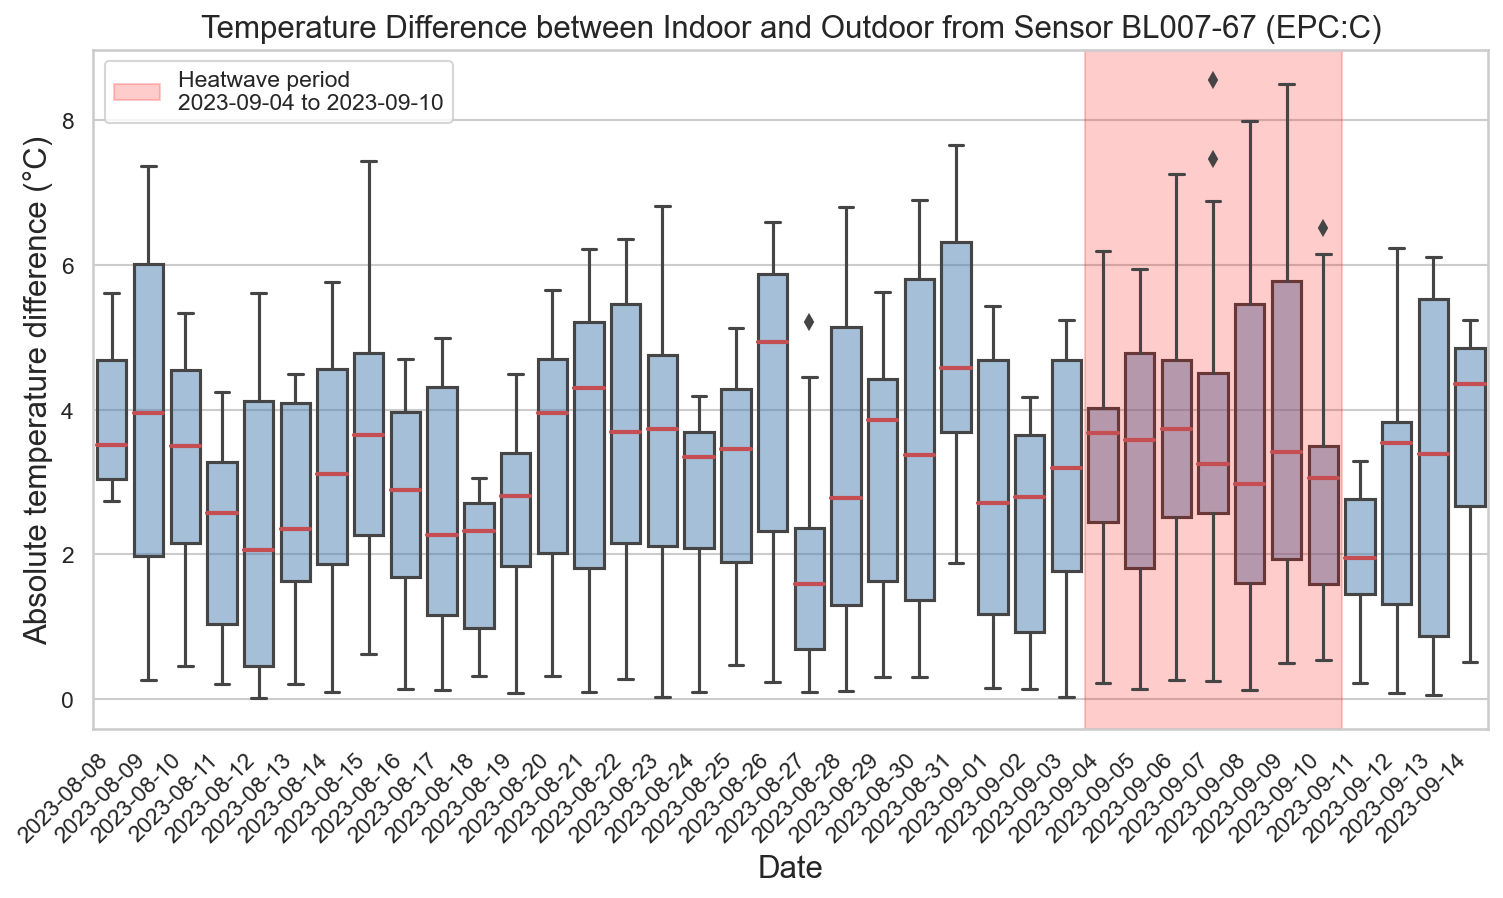

In [70]:
plot_2 = plot_tempdiff_group('BL007-67')